Useful links

https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from functools import partial

import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/posital-2-braccio/Posital 2 braccio.trc


In [2]:
# adjust these parameters

# data collection
fname = "../input/posital-2-braccio/Posital 2 braccio.trc"
rows_to_skip = 20

# data filter
command_rolling_length = 1
position_rolling_length = 1
velocity_rolling_length = 1

# keras model
labels_column_names = ['DV2']
output_dimension = len(labels_column_names)
model_filename= './model_1'

In [3]:
# utility function: convert hex string to unsigned int (es. FF00 -> 65280)
def hex2int_unsigned(hex_val):
    return int(hex_val,16)

In [4]:
# utility function: convert hex string to signed int (es. FF00 -> -256)
def hex2int_signed(hexval):
    bits = 16
    val = int(hexval, bits)
    if val & (1 << (bits-1)):
        val -= 1 << bits
    return val

In [5]:
# read text file into pandas DataFrame
df = pd.read_csv(
        fname,
        delim_whitespace=True, 
        skiprows = rows_to_skip, 
        header=None, 
        names=["N","O","T","B","I","d","R","L","D0","D1","D2","D3","D4","D5","D6","D7"],
        #nrows=10000,
        index_col = 'O',
        converters={
            'O': partial(pd.to_datetime,unit='ms',infer_datetime_format=True)
            #    'D0': partial(int, base=16),
        }
        
    )

# display DataFrame
df

,N,T,B,I,d,R,L,D0,D1,D2,D3,D4,D5,D6,D7
O,,,,,,,,,,,,,,,
1970-01-01 00:00:00.000059,1,DT,4,0181,Rx,-,4,06,B2,95,11,NaN,NaN,NaN,NaN
1970-01-01 00:00:00.001133,2,DT,4,0281,Rx,-,8,DF,B1,FF,FF,6E,11,01,00
1970-01-01 00:00:00.002679,3,DT,4,03B1,Rx,-,8,DE,01,66,03,6F,01,0E,02
1970-01-01 00:00:00.002910,4,DT,4,01B1,Rx,-,8,5C,03,9B,05,D1,06,22,03
1970-01-01 00:00:00.004752,5,DT,4,0CF02AE3,Rx,-,8,C5,7C,3A,7D,15,7B,00,05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:01:02.077336,75846,DT,4,08F02DE3,Rx,-,8,C8,80,C1,7D,00,7D,00,00
1970-01-01 00:01:02.077569,75847,DT,4,03B1,Rx,-,8,A8,01,15,03,17,01,E3,01
1970-01-01 00:01:02.077802,75848,DT,4,01B1,Rx,-,8,FD,02,BB,04,F4,04,46,02


In [6]:
# start_time = pd.to_datetime('26/05/2022 12:09:59.00')    
# converters = {'O': lambda x: pd.to_datetime(float(x), unit='ms', origin = start_time)}

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<AxesSubplot:xlabel='O'>

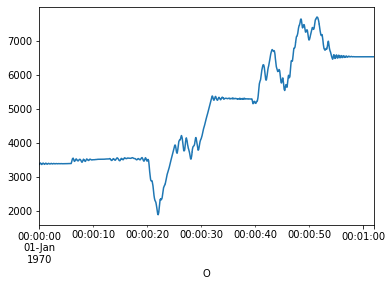

In [7]:
# select posital rows
posital = df[df["I"] == '0182']

# convert angle from hex bytes to unsigned int
posital['P2'] = (posital['D1'] + posital['D0']).apply(hex2int_unsigned)

# resample at 10 milliseconds
posital = posital.resample("10L").ffill()

posital['P2'].plot()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:xlabel='O'>

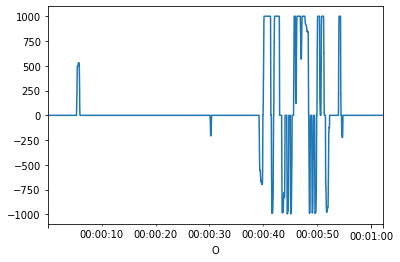

In [8]:
# select joystick rows
command = df[df["I"] == '02B2']

# convert set points from hex strings to signed int
command['C2'] = (command['D1'] + command['D0']).apply(hex2int_signed)
command['C1'] = (command['D3'] + command['D2']).apply(hex2int_signed)

# resample at 10 milliseconds
command = command.resample("10L").ffill()

command['C2'].plot()

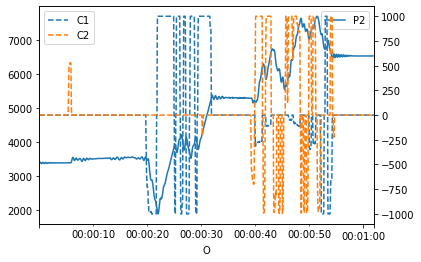

In [9]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

posital.plot(y=['P2'], ax=ax)
command.plot(y=["C1", "C2"], ax=ax2, ls="--")

plt.show()

In [10]:
min_length = min(command.shape[0], posital.shape[0])
min_length

6207

<AxesSubplot:xlabel='O'>

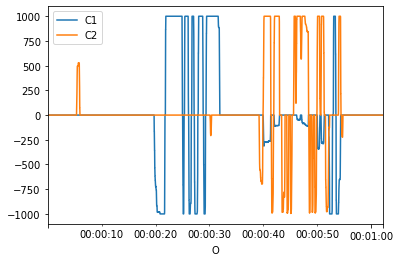

In [11]:
command = command[['C1','C2']].iloc[0:min_length].copy()
command = command.rolling(command_rolling_length).mean()
command.plot()

<AxesSubplot:xlabel='O'>

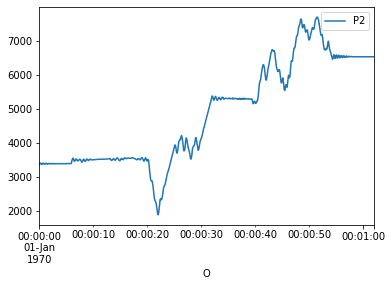

In [12]:
position = posital[['P2']].iloc[0:min_length].copy()

position = position.rolling(position_rolling_length).mean()
position.plot()

In [13]:
df2 = pd.merge(command, position, left_index=True, right_index=True)
df2

,C1,C2,P2
O,,,
1970-01-01 00:00:00.010,NaN,NaN,3366.0
1970-01-01 00:00:00.020,0.0,0.0,3369.0
1970-01-01 00:00:00.030,0.0,0.0,3371.0
1970-01-01 00:00:00.040,0.0,0.0,3374.0
1970-01-01 00:00:00.050,0.0,0.0,3377.0
...,...,...,...
1970-01-01 00:01:02.020,0.0,0.0,6523.0
1970-01-01 00:01:02.030,0.0,0.0,6523.0
1970-01-01 00:01:02.040,0.0,0.0,6523.0


<AxesSubplot:xlabel='O'>

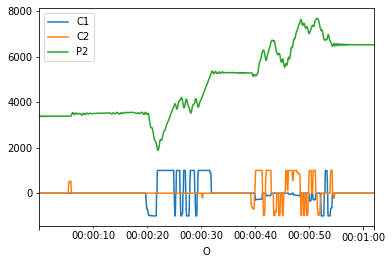

In [14]:
df2 = df2.dropna()
df2.plot()

In [15]:
df2.describe()

,C1,C2,P2
count,6205.000000,6205.000000,6205.000000
mean,39.349234,52.610959,4836.388719
std,437.829163,362.581454,1494.196815
min,-1000.000000,-995.000000,1886.000000
25%,0.000000,0.000000,3505.000000
50%,0.000000,0.000000,4765.000000
75%,0.000000,0.000000,6496.000000
max,1000.000000,1000.000000,7689.000000


In [16]:
df2.to_excel('df2.xlsx')

# Create additional columns

In [17]:
df3 = df2.copy()

In [18]:
df3

,C1,C2,P2
O,,,
1970-01-01 00:00:00.020,0.0,0.0,3369.0
1970-01-01 00:00:00.030,0.0,0.0,3371.0
1970-01-01 00:00:00.040,0.0,0.0,3374.0
1970-01-01 00:00:00.050,0.0,0.0,3377.0
1970-01-01 00:00:00.060,0.0,0.0,3380.0
...,...,...,...
1970-01-01 00:01:02.020,0.0,0.0,6523.0
1970-01-01 00:01:02.030,0.0,0.0,6523.0
1970-01-01 00:01:02.040,0.0,0.0,6523.0


In [19]:
C1_BASE = 3  # start from columns 3
C1_STEP = 3  # take 3 steps back
C1_SIZE = 33 # was 33 in the ETH model

C2_BASE = C1_BASE+C1_SIZE  # start from columns 3+5
C2_STEP = 3  # take 3 steps back
C2_SIZE = 33 # was 33 in the ETH model


V_BASE = C1_BASE+C1_SIZE+C2_SIZE 
V_STEP = 1 # take 1 step back
V_SIZE = 10 # was 10 in the ETH model

# create columns with past commands
for i in range(1,C1_SIZE+1):
    df3[C1_BASE+i] = df3['C1'].shift(i*C1_STEP)
    df3.rename(columns={C1_BASE+i:'C1-'+ str(i*C1_STEP)}, inplace=True)

for i in range(1,C2_SIZE+1):
    df3[C2_BASE+i] = df3['C2'].shift(i*C2_STEP)
    df3.rename(columns={C2_BASE+i:'C2-'+ str(i*C2_STEP)}, inplace=True)

# create velocities from positions
df3['V2'] = df3['P2']-df3['P2'].shift(1)

# filter velocities
df3['V2'] = df3['V2'].rolling(velocity_rolling_length).mean()

# create delta velocities from velocities
df3['DV2'] = df3['V2']-df3['V2'].shift(1)

# create columns with past velocities
for i in range(1,V_SIZE+1):
    df3[V_BASE+i] = df3['V2'].shift(i*V_STEP)
    df3.rename(columns={V_BASE+i:'V2-'+ str(i*V_STEP)}, inplace=True)


In [20]:
df3 = df3.fillna(0)
df3

,C1,C2,P2,C1-3,C1-6,C1-9,C1-12,C1-15,C1-18,C1-21,...,V2-1,V2-2,V2-3,V2-4,V2-5,V2-6,V2-7,V2-8,V2-9,V2-10
O,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00.020,0.0,0.0,3369.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970-01-01 00:00:00.030,0.0,0.0,3371.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970-01-01 00:00:00.040,0.0,0.0,3374.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970-01-01 00:00:00.050,0.0,0.0,3377.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970-01-01 00:00:00.060,0.0,0.0,3380.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:01:02.020,0.0,0.0,6523.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970-01-01 00:01:02.030,0.0,0.0,6523.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970-01-01 00:01:02.040,0.0,0.0,6523.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Use KERAS

In [21]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.6.4


In [22]:
keras_dataset=df3.copy()

In [23]:
# split dataset in train and test
train_dataset = keras_dataset.sample(frac=0.8, random_state=0)
test_dataset = keras_dataset.drop(train_dataset.index)

# extract features and labels into separate arrays
train_features = train_dataset.copy()
train_features = train_features.drop(labels_column_names, axis=1)
train_labels = train_dataset.loc[:, labels_column_names]

test_features = test_dataset.copy()
test_features = test_features.drop(labels_column_names, axis=1)
test_labels = test_dataset.loc[:, labels_column_names]

In [24]:
train_features

,C1,C2,P2,C1-3,C1-6,C1-9,C1-12,C1-15,C1-18,C1-21,...,V2-1,V2-2,V2-3,V2-4,V2-5,V2-6,V2-7,V2-8,V2-9,V2-10
O,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:15.970,0.0,0.0,3544.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-2.0
1970-01-01 00:00:41.850,0.0,-164.0,6010.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-13.0,-14.0,-15.0,-15.0,-16.0,-15.0,-16.0,-15.0,-16.0,-14.0
1970-01-01 00:01:01.980,0.0,0.0,6523.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970-01-01 00:00:11.620,0.0,0.0,3512.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0
1970-01-01 00:00:24.500,1000.0,0.0,3542.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,...,6.0,6.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:50.370,-311.0,1000.0,7223.0,-331.0,-340.0,-341.0,-342.0,-343.0,-342.0,-341.0,...,6.0,5.0,3.0,7.0,6.0,3.0,10.0,10.0,10.0,13.0
1970-01-01 00:00:55.550,0.0,0.0,6562.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,-1.0,0.0,4.0,0.0,5.0,7.0,6.0
1970-01-01 00:01:01.870,0.0,0.0,6523.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Normalization

In [25]:
# show train_dataset mean and std
train_dataset.describe().transpose()

# create a Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)  # many variables
# normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None) #one variable

# set mean and std for Normalization layer
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

2022-10-04 17:32:16.558408: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-10-04 17:32:16.649236: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


[[3.7551159e+01 5.4985912e+01 4.8341089e+03 3.6776981e+01 3.6354160e+01
  3.6044533e+01 3.6346508e+01 3.7081997e+01 3.7562244e+01 3.8153721e+01
  3.8720585e+01 3.9161968e+01 3.8374695e+01 3.8245152e+01 3.7686340e+01
  3.7390209e+01 3.7327953e+01 3.6684727e+01 3.5890404e+01 3.6096096e+01
  3.6632740e+01 3.6679512e+01 3.6393024e+01 3.6371475e+01 3.6089851e+01
  3.6449024e+01 3.7008457e+01 3.8121273e+01 3.8234486e+01 3.7886379e+01
  3.7845890e+01 3.8004230e+01 3.8122482e+01 3.7883980e+01 3.7752644e+01
  3.7174473e+01 5.5782833e+01 5.7036057e+01 5.7556622e+01 5.7706295e+01
  5.6933098e+01 5.6994179e+01 5.6663593e+01 5.6723217e+01 5.6735092e+01
  5.6743767e+01 5.6278599e+01 5.5981068e+01 5.5608181e+01 5.5746761e+01
  5.5644466e+01 5.5302780e+01 5.5282036e+01 5.5073730e+01 5.4836063e+01
  5.4358368e+01 5.4066071e+01 5.3980286e+01 5.3739731e+01 5.4231274e+01
  5.4585205e+01 5.4815063e+01 5.5244160e+01 5.5491718e+01 5.5818691e+01
  5.5974216e+01 5.6112411e+01 5.6337444e+01 5.6119457e+01 5.1954

## Utility functions

In [26]:
def plot_loss(history, ymax=100):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, ymax])
  plt.xlabel('Epoch')
  plt.ylabel('Error [y]')
  plt.legend()
  plt.grid(True)

## Regression using a DNN

In [27]:
# create keras model

dnn_model = keras.Sequential([
      normalizer,
      layers.Dense(units=128, activation='relu'),
      layers.Dense(units = 128, activation='relu'),
      layers.Dense(units=128, activation='relu'),
      layers.Dense(output_dimension)
  ])

dnn_model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 80)                161       
_________________________________________________________________
dense (Dense)                (None, 128)               10368     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 43,682
Trainable params: 43,521
Non-trainable params: 161
_________________________________________________________________


In [28]:
# train keras model

history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, 
    epochs=10
)

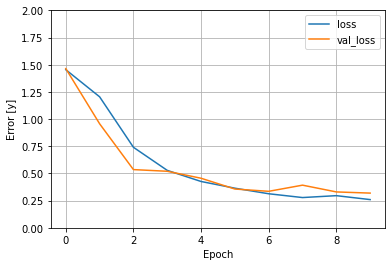

In [29]:
plot_loss(history,2)

## Evaluate model with test_data

In [30]:
# evaluate model loss with test_data 
test_results = {}
test_results = dnn_model.evaluate(test_features, test_labels, verbose=0)
test_results

0.2965330481529236

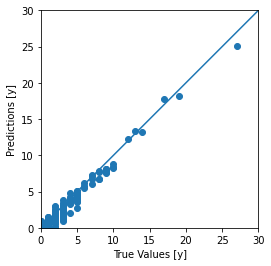

In [31]:
# compare test predictions with test labels
test_predictions = dnn_model.predict(test_features)

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [y]')
plt.ylabel('Predictions [y]')
lims = [0, 30]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

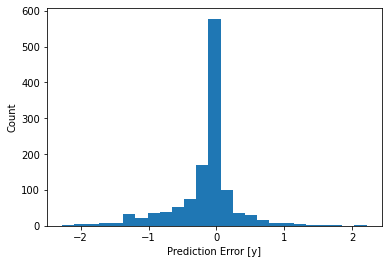

In [32]:
# evaluate predictions error
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [y]')
_ = plt.ylabel('Count')

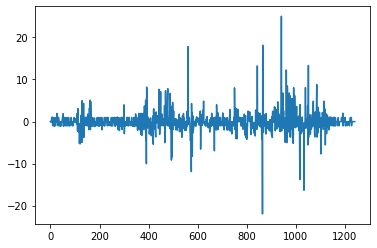

In [33]:
plt.plot(test_predictions)

<AxesSubplot:xlabel='O'>

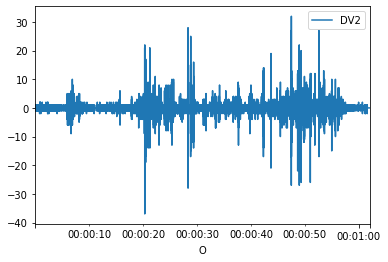

In [34]:
df3[labels_column_names].plot()

## Save and Load model

In [35]:
dnn_model.save(model_filename)

2022-10-04 17:32:23.168088: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [36]:
reloaded = tf.keras.models.load_model(model_filename)